- Use Black-Litterman model to get a posterior estimation of stocks' return

- Use sentiment score from alphavantage as views

- predict 10 days posterior expected returns with sentiment socre, make an array to store the date with the expected return then make portfolio optimization, compare the culmulative return (compare which with which?) dynamic adjust results with steady weight results?


In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

In [25]:
tickers = ["AAPL", "AMZN", "META", "NFLX", "COST", "DIS"]
# tickers = ['AAPL', 'AMZN', 'COST', 'DIS', 'GOOGL', 'JPM', 'LLY',  'MSFT','META', 'NFLX', 'NVDA', 'TSLA']
start_date = "2024-07-27"
end_date = '2024-08-22'
ohlc = yf.download(tickers, start = start_date, end=end_date)
# ohlc = yf.download(tickers, period="max") 
prices = ohlc["Adj Close"]

# SPY: SPDR S&P 500 ETF Trust. It is designed to track the S&P 500 stock market index. This fund is the largest and oldest ETF in the USA.
market_prices = yf.download("SPY", start = start_date, end=end_date)["Adj Close"]
# market_prices = yf.download("SPY", period="max")["Adj Close"]

# market_prices.head()

[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed


In [26]:
prices 

Ticker,AAPL,AMZN,COST,DIS,META,NFLX
Date,,,,,,
2024-07-29,217.987686,183.199997,815.559998,92.139999,465.709991,626.960022
2024-07-30,218.547043,181.710007,810.030029,93.790001,463.190002,622.580017
2024-07-31,221.823242,186.979996,822.000000,93.690002,474.829987,628.349976
2024-08-01,218.107544,184.070007,816.890015,93.050003,497.739990,624.849976
2024-08-02,219.605804,167.899994,822.080017,89.570000,488.140015,613.640015
2024-08-05,209.028061,161.020004,801.830017,87.779999,475.730011,598.549988
2024-08-06,206.990402,161.929993,816.880005,89.970001,494.089996,609.570007
2024-08-07,209.577423,162.770004,810.299988,85.959999,488.920013,611.479980
2024-08-08,213.063385,165.800003,839.429993,85.959999,509.630005,630.349976


<Axes: xlabel='Date'>

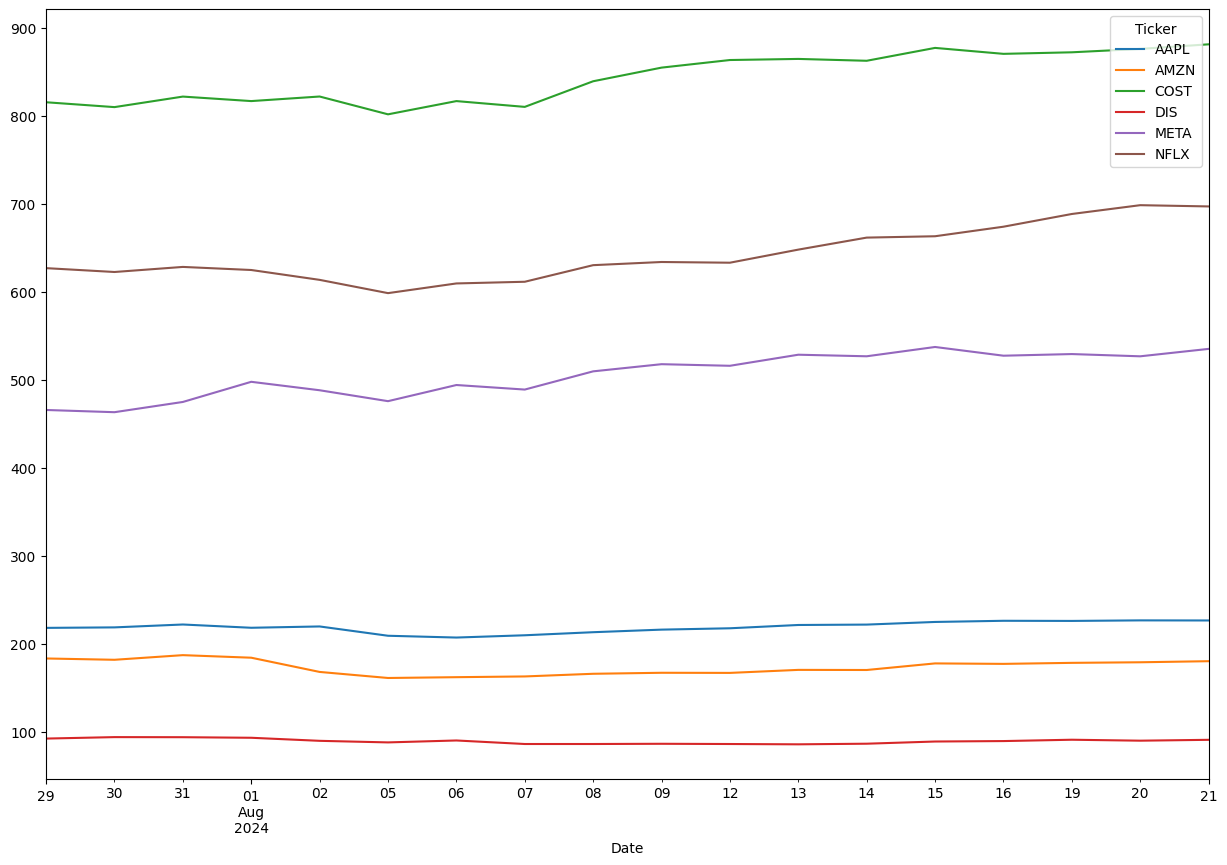

In [27]:
prices.plot(figsize=(15,10))

# Calculate the market implied prior returns

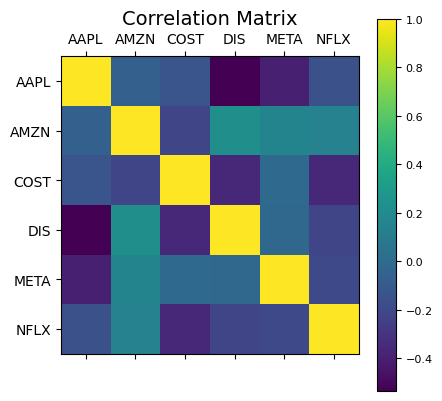

In [28]:
import pypfopt
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel

mcaps = {}
for t in tickers:
    stock = yf.Ticker(t)
    mcaps[t] = stock.info["marketCap"]
S = risk_models.CovarianceShrinkage(prices).ledoit_wolf() # Covariance Matrix of asset returns

# Plot correlation matrix
plt.matshow(S.corr())
plt.xticks(range(S.select_dtypes(['number']).shape[1]), S.select_dtypes(['number']).columns, fontsize=10)
plt.yticks(range(S.select_dtypes(['number']).shape[1]), S.select_dtypes(['number']).columns, fontsize=10)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=8)
plt.title('Correlation Matrix', fontsize=14)

delta = black_litterman.market_implied_risk_aversion(market_prices) # Prior estimate of returns, calculated by the market’s excess return divided by its variance: (R-R_f)/sig^2
market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)

# Use sentiment score from alphavantage to calculate the veiws
Use sentiment score gamma to calculate new stock price

  $$ S_T=   \left\{
\begin{array}{ll}
      S_0+[(S_{MC}^+ -S_0) \cdot \gamma] & \text{ if }  \gamma \text{ in } (0, 1] \\
      S_0-[(S_0 - S_{MC}^-) \cdot  \gamma] & \text{ if } \gamma \text{ in } [-1, 0) \\
\end{array} 
\right.  $$
We need to use Monte Carlo to simulate possible stock prices to get $S_{MC}^-$ and $S_{MC}^+$.

Then 
$$Views= \ln (\frac{S_T}{S_0})$$

In [29]:
def get_data(ticker):
    df_news = pd.read_csv(f'../data/{ticker}_news_data.csv', index_col='date',parse_dates=True,dtype=float)
    return df_news
sentiment = {}
confidence = {}
for ticker in tickers:
    sentiment[ticker] = get_data(ticker)['sentiment_score']
    confidence[ticker]  = get_data(ticker)['relevance_score']

Be careful, the date need to be matched, so we need to accept NaN value in the news_data. When it's NaN, just simply not include it in the view list

In [30]:
df_sentiment = pd.concat([sentiment['AAPL'], sentiment['AMZN'], sentiment['META'], sentiment['NFLX'], sentiment['COST'], sentiment['DIS']], axis=1, keys= ['AAPL_score', 'AMZN_score', 'META_score', 'NFLX_score', 'COST_score', 'DIS_score'])
df_sentiment

,AAPL_score,AMZN_score,META_score,NFLX_score,COST_score,DIS_score
date,,,,,,
2023-10-25,NaN,NaN,NaN,NaN,NaN,-0.067043
2023-10-26,NaN,NaN,NaN,NaN,NaN,0.072892
2023-10-27,NaN,NaN,NaN,NaN,NaN,0.067254
2023-10-28,NaN,NaN,NaN,NaN,NaN,0.109823
2023-10-30,NaN,NaN,NaN,NaN,NaN,0.021702
...,...,...,...,...,...,...
2024-08-18,0.300287,0.252954,0.022614,0.089222,0.710543,NaN
2024-08-19,0.200851,0.122735,0.110503,0.290985,0.313231,-0.030021
2024-08-20,0.126437,0.251271,0.112768,0.350775,0.275696,NaN


In [31]:
df_confidence = pd.concat([confidence['AAPL'], confidence['AMZN'], confidence['META'], confidence['NFLX'], confidence['COST'], confidence['DIS']], axis=1, keys= ['AAPL_confidence', 'AMZN_confidence', 'META_confidence', 'NFLX_confidence', 'COST_confidence', 'DIS_confidence'])
df_confidence

,AAPL_confidence,AMZN_confidence,META_confidence,NFLX_confidence,COST_confidence,DIS_confidence
date,,,,,,
2023-10-25,NaN,NaN,NaN,NaN,NaN,0.231671
2023-10-26,NaN,NaN,NaN,NaN,NaN,0.025033
2023-10-27,NaN,NaN,NaN,NaN,NaN,0.039628
2023-10-28,NaN,NaN,NaN,NaN,NaN,0.066826
2023-10-30,NaN,NaN,NaN,NaN,NaN,0.213115
...,...,...,...,...,...,...
2024-08-18,0.490745,0.439466,0.068922,0.058922,0.568435,NaN
2024-08-19,0.194084,0.190895,0.090052,0.223062,0.282477,0.106778
2024-08-20,0.196556,0.230113,0.081662,0.439785,0.443306,NaN


In [32]:
df_sentiment_interested  = df_sentiment.loc[start_date:end_date]
df_confidence_interested  = df_confidence.loc[start_date:end_date]

# df_sentiment_interested

In [33]:
df = pd.concat([prices, df_sentiment_interested, df_confidence_interested], axis=1)
df

,AAPL,AMZN,COST,DIS,META,NFLX,AAPL_score,AMZN_score,META_score,NFLX_score,COST_score,DIS_score,AAPL_confidence,AMZN_confidence,META_confidence,NFLX_confidence,COST_confidence,DIS_confidence
2024-07-27,NaN,NaN,NaN,NaN,NaN,NaN,0.212715,0.144378,NaN,NaN,NaN,NaN,0.308530,0.198954,NaN,NaN,NaN,NaN
2024-07-28,NaN,NaN,NaN,NaN,NaN,NaN,0.265542,0.240842,NaN,0.052980,NaN,NaN,0.448540,0.267663,NaN,0.058781,NaN,NaN
2024-07-29,217.987686,183.199997,815.559998,92.139999,465.709991,626.960022,0.101860,0.197932,NaN,0.285436,0.080795,0.092362,0.263385,0.282078,NaN,0.276412,0.275742,0.112269
2024-07-30,218.547043,181.710007,810.030029,93.790001,463.190002,622.580017,0.251976,0.145506,NaN,0.028290,0.132093,0.000000,0.277254,0.344981,NaN,0.299069,0.118868,0.252987
2024-07-31,221.823242,186.979996,822.000000,93.690002,474.829987,628.349976,0.166835,0.260574,NaN,0.083248,0.325152,0.283600,0.265378,0.386931,NaN,0.178037,0.325478,0.047813
2024-08-01,218.107544,184.070007,816.890015,93.050003,497.739990,624.849976,0.304408,0.257015,NaN,0.210935,0.447013,0.210345,0.340248,0.285609,NaN,0.312481,0.338541,0.031915
2024-08-02,219.605804,167.899994,822.080017,89.570000,488.140015,613.640015,0.260843,0.171762,NaN,0.071971,0.186498,0.174688,0.361847,0.269612,NaN,0.119456,0.143875,0.044222
2024-08-03,NaN,NaN,NaN,NaN,NaN,NaN,0.340814,-0.354979,NaN,0.451888,0.506643,NaN,0.450345,0.321191,NaN,0.631558,0.332224,NaN
2024-08-04,NaN,NaN,NaN,NaN,NaN,NaN,0.223156,0.216377,NaN,0.214076,0.266628,NaN,0.277556,0.202374,NaN,0.045396,0.524142,NaN
2024-08-05,209.028061,161.020004,801.830017,87.779999,475.730011,598.549988,0.176551,0.175071,NaN,0.134193,0.237317,0.166617,0.409143,0.274334,NaN,0.149719,0.200118,0.162414


In [34]:
# less NaN value
short_start_date = '2024-08-07'
df = df.loc[short_start_date:end_date].copy()

In [35]:
len(prices) # need to add NAN for the date doesn't have a price, less prices data than sentiment score.

18

In [36]:
len(df) 

16

## Monte Carlo simulation for stock prices

In [37]:
# Calculate log returns
log_returns = np.log(prices / prices.shift(1)).dropna()

# Estimate parameters
mean_return = log_returns.mean()
volatility = log_returns.std()

# Monte Carlo simulation parameters
num_simulations = 1000
num_days = 5  # Number of trading days to simulate 

# Step 4: Simulate future prices
def monte_carlo_simulation(start_price, mean_return, volatility, num_days, num_simulations):
    simulated_prices = np.zeros((num_days, num_simulations))
    simulated_prices[0] = start_price

    for t in range(1, num_days):
        random_shocks = np.random.normal(loc=mean_return, scale=volatility, size=num_simulations)
        simulated_prices[t] = simulated_prices[t - 1] * np.exp(random_shocks)
    
    return simulated_prices

def NewStockPrice(gamma, S, S0):
    if gamma <0:
        S_T= S0 - (S0 - S.min())*gamma
    else:
        S_T= S0 + (S.max() - S0)*gamma
    return S_T


## calculate the views

In [38]:
from math import nan
days = len(df)
viewdict = {}
for ticker in tickers:
    ST_data = []
    for i in range(days):
        if np.isnan(df[ticker].iloc[i]):
            simulated_prices = nan
            ST = nan
            df[f'{ticker}_confidence'].values[i] = nan
        else:
            start_price = df[ticker].iloc[i] # need to modify this start price, changed daily
            simulated_prices = monte_carlo_simulation(start_price, mean_return[ticker], volatility[ticker], num_days, num_simulations)
            if np.isnan(df[f'{ticker}_score'].iloc[i-1]): # if sentiment score is nan, we use the mean for simulated_prices
                ST = simulated_prices.mean()
            else:
                ST = NewStockPrice(df[f'{ticker}_score'].iloc[i-1], simulated_prices, start_price)
        ST_data.append(ST)  
    df[f'{ticker}_ST'] = ST_data
    df[f'{ticker}_view'] =  (df[f'{ticker}_ST']-df[ticker])/df[f'{ticker}_ST']

In [39]:
df

,AAPL,AMZN,COST,DIS,META,NFLX,AAPL_score,AMZN_score,META_score,NFLX_score,...,AMZN_ST,AMZN_view,META_ST,META_view,NFLX_ST,NFLX_view,COST_ST,COST_view,DIS_ST,DIS_view
2024-08-07,209.577423,162.770004,810.299988,85.959999,488.920013,611.479980,0.210054,0.232361,0.194764,0.140378,...,162.484068,-0.001760,488.920013,0.000000,619.382494,0.012759,818.312174,0.009791,85.911674,-0.000562
2024-08-08,213.063385,165.800003,839.429993,85.959999,509.630005,630.349976,0.095913,0.222397,0.059341,0.203012,...,173.862660,0.046374,530.440172,0.039232,639.896863,0.014919,852.524238,0.015359,87.609381,0.018827
2024-08-09,215.990005,166.940002,854.929993,86.209999,517.770020,633.940002,0.112943,0.110259,0.124186,0.098521,...,173.530236,0.037977,523.075782,0.010143,650.722174,0.025790,873.263126,0.020994,86.752045,0.006248
2024-08-10,NaN,NaN,NaN,NaN,NaN,NaN,0.274147,0.246673,0.019719,0.071907,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-08-11,NaN,NaN,NaN,NaN,NaN,NaN,0.285419,0.155372,0.118520,0.457512,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-08-12,217.529999,166.800003,863.570007,85.949997,515.950012,633.140015,0.215949,0.114624,0.185444,0.099501,...,172.606180,0.033638,527.836384,0.022519,673.541691,0.059984,871.281315,0.008851,87.326729,0.015765
2024-08-13,221.270004,170.229996,864.820007,85.599998,528.539978,648.020020,0.345127,0.334976,0.229597,0.353852,...,174.348507,0.023622,547.828204,0.035209,656.776694,0.013333,889.821774,0.028097,87.404240,0.020642
2024-08-14,221.720001,170.100006,862.710022,86.300003,526.760010,661.679993,0.161013,0.229761,0.120054,0.254439,...,180.562564,0.057944,549.628974,0.041608,692.398099,0.044365,897.043363,0.038274,86.209716,-0.001047
2024-08-15,224.720001,177.589996,877.349976,88.790001,537.330017,663.219971,0.315378,0.326461,0.005266,0.202177,...,184.557337,0.037752,549.701909,0.022507,682.615088,0.028413,906.427446,0.032079,91.051422,0.024837
2024-08-16,226.050003,177.059998,870.590027,89.300003,527.419983,674.070007,0.206961,0.107876,0.144996,0.247201,...,188.218670,0.059286,527.984757,0.001070,690.250541,0.023442,905.515797,0.038570,92.321018,0.032723


In [43]:
df = df.dropna()
df

,AAPL,AMZN,COST,DIS,META,NFLX,AAPL_score,AMZN_score,META_score,NFLX_score,...,AMZN_ST,AMZN_view,META_ST,META_view,NFLX_ST,NFLX_view,COST_ST,COST_view,DIS_ST,DIS_view
2024-08-07,209.577423,162.770004,810.299988,85.959999,488.920013,611.479980,0.210054,0.232361,0.194764,0.140378,...,162.484068,-0.001760,488.920013,0.000000,619.382494,0.012759,818.312174,0.009791,85.911674,-0.000562
2024-08-08,213.063385,165.800003,839.429993,85.959999,509.630005,630.349976,0.095913,0.222397,0.059341,0.203012,...,173.862660,0.046374,530.440172,0.039232,639.896863,0.014919,852.524238,0.015359,87.609381,0.018827
2024-08-09,215.990005,166.940002,854.929993,86.209999,517.770020,633.940002,0.112943,0.110259,0.124186,0.098521,...,173.530236,0.037977,523.075782,0.010143,650.722174,0.025790,873.263126,0.020994,86.752045,0.006248
2024-08-12,217.529999,166.800003,863.570007,85.949997,515.950012,633.140015,0.215949,0.114624,0.185444,0.099501,...,172.606180,0.033638,527.836384,0.022519,673.541691,0.059984,871.281315,0.008851,87.326729,0.015765
2024-08-14,221.720001,170.100006,862.710022,86.300003,526.760010,661.679993,0.161013,0.229761,0.120054,0.254439,...,180.562564,0.057944,549.628974,0.041608,692.398099,0.044365,897.043363,0.038274,86.209716,-0.001047
2024-08-15,224.720001,177.589996,877.349976,88.790001,537.330017,663.219971,0.315378,0.326461,0.005266,0.202177,...,184.557337,0.037752,549.701909,0.022507,682.615088,0.028413,906.427446,0.032079,91.051422,0.024837
2024-08-16,226.050003,177.059998,870.590027,89.300003,527.419983,674.070007,0.206961,0.107876,0.144996,0.247201,...,188.218670,0.059286,527.984757,0.001070,690.250541,0.023442,905.515797,0.038570,92.321018,0.032723
2024-08-19,225.889999,178.220001,872.349976,90.820000,529.280029,688.530029,0.200851,0.122735,0.110503,0.290985,...,186.332987,0.043540,531.164773,0.003548,696.536663,0.011495,945.496347,0.077363,90.641958,-0.001964
2024-08-21,226.399994,180.110001,881.419983,90.720001,535.159973,697.119995,0.167170,0.198059,0.070689,0.114896,...,191.916740,0.061520,546.539482,0.020821,732.820775,0.048717,910.302143,0.031728,90.585244,-0.001488


In [41]:
len(df)

9

In [42]:
from pypfopt import EfficientFrontier, objective_functions

for i in range(len(df)):
    viewdict={}
    confidence_array = []
    for ticker in tickers:
        viewdict[ticker] = df[f'{ticker}_view'].values[i]
        confidence_array.append(df[f'{ticker}_confidence'].values[i])
    bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict, omega="idzorek", view_confidences=confidence_array)
    # Posterior estimate of returns
    ret_bl = bl.bl_returns()
    rets_df = pd.DataFrame([market_prior, ret_bl, pd.Series(viewdict)], 
                index=["Prior", "Posterior", "Views"]).T
    
    # Portfolio optimization by mean-variance 
    S_bl = bl.bl_cov()
    ef = EfficientFrontier(ret_bl, S_bl)
    ef.add_objective(objective_functions.L2_reg)
    ef.max_sharpe(risk_free_rate=0.0)
    weights = ef.clean_weights()
    print('dynamic portfolio:',i, weights)
    
    # rets_df.plot.bar(figsize=(12,8))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional object

dynamic portfolio: 0 OrderedDict([('AAPL', 0.24416), ('AMZN', 0.27685), ('COST', 0.10006), ('DIS', 0.08345), ('META', 0.19064), ('NFLX', 0.10484)])
dynamic portfolio: 1 OrderedDict([('AAPL', 0.23706), ('AMZN', 0.27808), ('COST', 0.08977), ('DIS', 0.08192), ('META', 0.20517), ('NFLX', 0.108)])
dynamic portfolio: 2 OrderedDict([('AAPL', 0.28235), ('AMZN', 0.30431), ('COST', 0.06033), ('DIS', 0.04259), ('META', 0.20375), ('NFLX', 0.10668)])
dynamic portfolio: 3 OrderedDict([('AAPL', 0.23653), ('AMZN', 0.28887), ('COST', 0.09619), ('DIS', 0.08187), ('META', 0.18978), ('NFLX', 0.10676)])
dynamic portfolio: 4 OrderedDict([('AAPL', 0.24462), ('AMZN', 0.27357), ('COST', 0.0972), ('DIS', 0.09173), ('META', 0.1889), ('NFLX', 0.10399)])
dynamic portfolio: 5 OrderedDict([('AAPL', 0.24416), ('AMZN', 0.27353), ('COST', 0.09198), ('DIS', 0.08361), ('META', 0.19884), ('NFLX', 0.10789)])
dynamic portfolio: 6 OrderedDict([('AAPL', 0.24544), ('AMZN', 0.29625), ('COST', 0.08815), ('DIS', 0.09601), ('META'

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


# Compare the results from dynamic portfolio allocation and from even weights



In [66]:
import yfinance as yf
import pandas as pd
from collections import OrderedDict

# Define the dynamic portfolios over the nine days
dynamic_portfolios = [
    OrderedDict([('AAPL', 0.24416), ('AMZN', 0.27685), ('COST', 0.10006), ('DIS', 0.08345), ('META', 0.19064), ('NFLX', 0.10484)]),
    OrderedDict([('AAPL', 0.23706), ('AMZN', 0.27808), ('COST', 0.08977), ('DIS', 0.08192), ('META', 0.20517), ('NFLX', 0.108)]),
    OrderedDict([('AAPL', 0.28235), ('AMZN', 0.30431), ('COST', 0.06033), ('DIS', 0.04259), ('META', 0.20375), ('NFLX', 0.10668)]),
    OrderedDict([('AAPL', 0.23653), ('AMZN', 0.28887), ('COST', 0.09619), ('DIS', 0.08187), ('META', 0.18978), ('NFLX', 0.10676)]),
    OrderedDict([('AAPL', 0.24462), ('AMZN', 0.27357), ('COST', 0.0972), ('DIS', 0.09173), ('META', 0.1889), ('NFLX', 0.10399)]),
    OrderedDict([('AAPL', 0.24416), ('AMZN', 0.27353), ('COST', 0.09198), ('DIS', 0.08361), ('META', 0.19884), ('NFLX', 0.10789)]),
    OrderedDict([('AAPL', 0.24544), ('AMZN', 0.29625), ('COST', 0.08815), ('DIS', 0.09601), ('META', 0.19195), ('NFLX', 0.08221)]),
    OrderedDict([('AAPL', 0.2473), ('AMZN', 0.28267), ('COST', 0.10175), ('DIS', 0.08425), ('META', 0.18843), ('NFLX', 0.09559)]),
    OrderedDict([('AAPL', 0.23659), ('AMZN', 0.26855), ('COST', 0.10296), ('DIS', 0.08785), ('META', 0.19265), ('NFLX', 0.11139)])
]

# List of tickers
tickers = ['AAPL', 'AMZN', 'COST', 'DIS', 'META', 'NFLX']

# Download historical data for the specified date range
start_date = '2024-08-07'
end_date = '2024-08-21'
data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']

# Calculate daily returns for each stock
daily_returns = data.pct_change().dropna()

# Calculate daily portfolio returns based on dynamic allocations
dynamic_portfolio_returns = []
for i, portfolio in enumerate(dynamic_portfolios):
    if i < len(daily_returns):
        daily_return = daily_returns.iloc[i]
        portfolio_return = sum(portfolio[stock] * daily_return[stock] for stock in portfolio)
        dynamic_portfolio_returns.append(portfolio_return)

# Convert to DataFrame for better handling
dynamic_portfolio_returns_df = pd.DataFrame(dynamic_portfolio_returns, columns=['Daily Portfolio Return'])
dynamic_portfolio_returns_df.index = daily_returns.index[:len(dynamic_portfolio_returns_df)]
# Calculate cumulative returns
dynamic_portfolio_returns_df['Dynamic Cumulative Return'] = (1 + dynamic_portfolio_returns_df['Daily Portfolio Return']).cumprod() - 1

# # Display results
# print(dynamic_portfolio_returns_df)



[*********************100%%**********************]  6 of 6 completed


In [67]:

dynamic_portfolio_returns_df


,Daily Portfolio Return,Dynamic Cumulative Return
Date,,
2024-08-08,0.024122,0.024122
2024-08-09,0.010956,0.035343
2024-08-12,0.001388,0.036780
2024-08-13,0.016953,0.054357
2024-08-14,0.002357,0.056842
2024-08-15,0.023562,0.081744
2024-08-16,-0.001754,0.079846
2024-08-19,0.006032,0.086359
2024-08-20,0.001745,0.088255


In [68]:
# Calculate daily returns for an evenly weighted portfolio
equal_weight = 1 / len(tickers)
equal_portfolio_returns = daily_returns.dot([equal_weight] * len(tickers))
# Calculate cumulative returns for the evenly weighted portfolio
equal_portfolio_returns_df = pd.DataFrame(equal_portfolio_returns, columns=['Daily Equal Portfolio Return'])
equal_portfolio_returns_df['Equal Cumulative Return'] = (1 + equal_portfolio_returns_df['Daily Equal Portfolio Return']).cumprod() - 1


In [69]:
dynamic_portfolio_returns_df

,Daily Portfolio Return,Dynamic Cumulative Return
Date,,
2024-08-08,0.024122,0.024122
2024-08-09,0.010956,0.035343
2024-08-12,0.001388,0.036780
2024-08-13,0.016953,0.054357
2024-08-14,0.002357,0.056842
2024-08-15,0.023562,0.081744
2024-08-16,-0.001754,0.079846
2024-08-19,0.006032,0.086359
2024-08-20,0.001745,0.088255


In [70]:
equal_portfolio_returns_df

,Daily Equal Portfolio Return,Equal Cumulative Return
Date,,
2024-08-08,0.024069,0.024069
2024-08-09,0.010609,0.034934
2024-08-12,0.001434,0.036418
2024-08-13,0.013839,0.050761
2024-08-14,0.004120,0.055090
2024-08-15,0.020963,0.077208
2024-08-16,-0.000185,0.077009
2024-08-19,0.008311,0.085960
2024-08-20,0.001448,0.087532


In [71]:
# Merge the cumulative returns for comparison
cumulative_returns = pd.concat([
    dynamic_portfolio_returns_df['Dynamic Cumulative Return'],
    equal_portfolio_returns_df['Equal Cumulative Return']
], axis=1)
cumulative_returns

,Dynamic Cumulative Return,Equal Cumulative Return
Date,,
2024-08-08,0.024122,0.024069
2024-08-09,0.035343,0.034934
2024-08-12,0.036780,0.036418
2024-08-13,0.054357,0.050761
2024-08-14,0.056842,0.055090
2024-08-15,0.081744,0.077208
2024-08-16,0.079846,0.077009
2024-08-19,0.086359,0.085960
2024-08-20,0.088255,0.087532


Final Dynamic Portfolio Return: 0.0883
Final Equal Weight Portfolio Return: 0.0875
Additional Profit Gained by Using Dynamic Portfolio: 0.0007


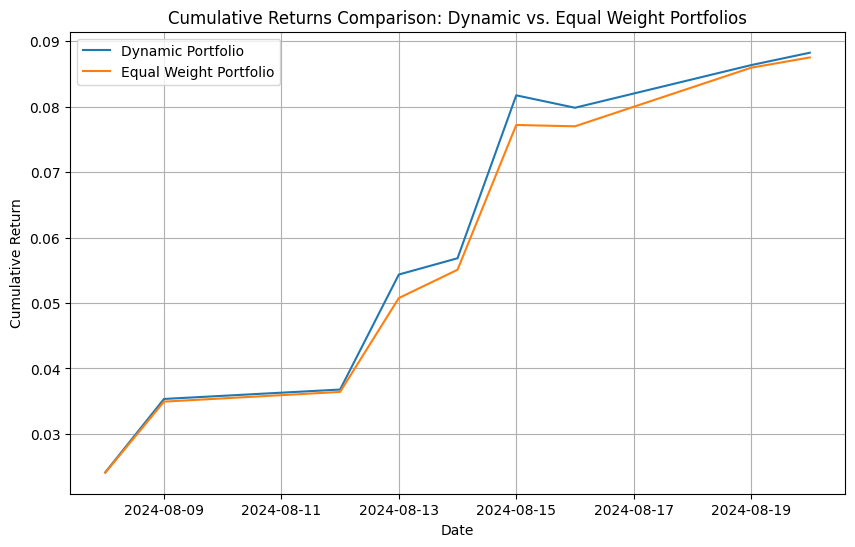

In [73]:
# Quantify the additional profit gained by using the dynamic portfolio
final_dynamic_return = dynamic_portfolio_returns_df['Dynamic Cumulative Return'].iloc[-1]
final_equal_return = equal_portfolio_returns_df['Equal Cumulative Return'].iloc[-1]
additional_profit = final_dynamic_return - final_equal_return

print(f"Final Dynamic Portfolio Return: {final_dynamic_return:.4f}")
print(f"Final Equal Weight Portfolio Return: {final_equal_return:.4f}")
print(f"Additional Profit Gained by Using Dynamic Portfolio: {additional_profit:.4f}")

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(cumulative_returns.index, cumulative_returns['Dynamic Cumulative Return'], label='Dynamic Portfolio')
plt.plot(cumulative_returns.index, cumulative_returns['Equal Cumulative Return'], label='Equal Weight Portfolio')
plt.title('Cumulative Returns Comparison: Dynamic vs. Equal Weight Portfolios')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()